### Data Processing

In [1]:
%%time
import pandas as pd
import numpy as np
import copy
from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import  MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from time import time
from chart_studio import plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
from sklearn.metrics import mean_absolute_error


import warnings
warnings.filterwarnings("ignore")
#import xgboost
import xgboost as xgb
import  lightgbm as lgb
%matplotlib inline

CPU times: user 3.65 s, sys: 644 ms, total: 4.29 s
Wall time: 4.94 s


In [2]:
%%time
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 23.6 µs


In [3]:
%%time
data= pd.read_csv('../data/ProductDemand.csv')

CPU times: user 1.72 s, sys: 215 ms, total: 1.94 s
Wall time: 2.44 s


In [4]:
data.nunique()

Product_Code        2160
Warehouse              4
Product_Category      33
Date                1729
Order_Demand        3828
dtype: int64

In [5]:
data.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [6]:
print(data.shape)

(1048575, 5)


In [7]:
data.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [8]:
data.dropna(axis=0,inplace=True)

In [9]:
data.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [10]:
data.shape

(1037336, 5)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037336 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1037336 non-null  object
 1   Warehouse         1037336 non-null  object
 2   Product_Category  1037336 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1037336 non-null  object
dtypes: object(5)
memory usage: 47.5+ MB


### Splitting into various columns

In [12]:
data[['Product','Product_Code']] = data.Product_Code.str.split("_",expand=True,)

In [13]:
data.drop('Product',axis=1,inplace=True)

In [14]:
data[['Ware','Warehouse']] = data.Warehouse.str.split("_",expand=True,)

In [15]:
data.drop('Ware',axis=1,inplace=True)

In [16]:


data[['Product','Product_Category']] = data.Product_Category.str.split("_",expand=True,)

In [17]:
data.drop('Product',axis=1,inplace=True)

In [18]:
data

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,0993,J,028,2012/7/27,100
1,0979,J,028,2012/1/19,500
2,0979,J,028,2012/2/3,500
3,0979,J,028,2012/2/9,500
4,0979,J,028,2012/3/2,500
...,...,...,...,...,...
1048570,1791,J,006,2016/4/27,1000
1048571,1974,J,006,2016/4/27,1
1048572,1787,J,006,2016/4/28,2500
1048573,0901,J,023,2016/10/7,50


In [19]:
#converting date format
data['Date'] = pd.to_datetime(data['Date'])

In [20]:
data

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,0993,J,028,2012-07-27,100
1,0979,J,028,2012-01-19,500
2,0979,J,028,2012-02-03,500
3,0979,J,028,2012-02-09,500
4,0979,J,028,2012-03-02,500
...,...,...,...,...,...
1048570,1791,J,006,2016-04-27,1000
1048571,1974,J,006,2016-04-27,1
1048572,1787,J,006,2016-04-28,2500
1048573,0901,J,023,2016-10-07,50


In [21]:
data.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                object
dtype: object

In [22]:
data.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [23]:
data['Order_Demand'] = data['Order_Demand'].astype(int,errors='ignore')

In [24]:
data.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                object
dtype: object

In [25]:
data['Date'] =pd.to_datetime(data.Date) + pd.offsets.DateOffset(years=5)

In [26]:
data

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,0993,J,028,2017-07-27,100
1,0979,J,028,2017-01-19,500
2,0979,J,028,2017-02-03,500
3,0979,J,028,2017-02-09,500
4,0979,J,028,2017-03-02,500
...,...,...,...,...,...
1048570,1791,J,006,2021-04-27,1000
1048571,1974,J,006,2021-04-27,1
1048572,1787,J,006,2021-04-28,2500
1048573,0901,J,023,2021-10-07,50


### Perform one hot encoding to Warehouse

#### One-hot encoding is a method used to represent categorical data in a format that a machine learning algorithm can understand. It involves converting the data into a vector of binary values, with a 1 in the position of the category that the data belongs to and 0s in all other positions.

In [27]:
# check unique values in warehouse column
data['Warehouse'].unique()

array(['J', 'S', 'C', 'A'], dtype=object)

In [28]:
#data = pd.get_dummies(data, columns=['Warehouse'])

In [29]:
data['Warehouse']=data['Warehouse'].replace('A',1)

In [30]:
data['Warehouse']=data['Warehouse'].replace('C',2)

In [31]:
data['Warehouse']=data['Warehouse'].replace('J',4)

In [32]:
data['Warehouse']=data['Warehouse'].replace('S',3)

In [33]:
data.head(4)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,0993,4,028,2017-07-27,100
1,0979,4,028,2017-01-19,500
2,0979,4,028,2017-02-03,500
3,0979,4,028,2017-02-09,500


### Change dtypes to int

In [34]:
data.dtypes

Product_Code                object
Warehouse                    int64
Product_Category            object
Date                datetime64[ns]
Order_Demand                object
dtype: object

In [35]:
# convert multiple columns to integer
data[['Product_Code','Product_Category']] = data[['Product_Code','Product_Category']].astype(int)

In [36]:
data["Order_Demand"] = pd.to_numeric(data["Order_Demand"], errors='coerce')

In [37]:
data.dropna(axis=0,inplace=True)

In [38]:
data[['Order_Demand']] = data[['Order_Demand']].astype(int)

In [39]:
data.shape

(1031437, 5)

In [40]:
data.dtypes

Product_Code                 int64
Warehouse                    int64
Product_Category             int64
Date                datetime64[ns]
Order_Demand                 int64
dtype: object

In [41]:
data.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [42]:
#rearranging columns
data = data.reindex(columns=['Date', 'Warehouse','Product_Code','Product_Category','Order_Demand'])

In [43]:
data

,Date,Warehouse,Product_Code,Product_Category,Order_Demand
0,2017-07-27,4,993,28,100
1,2017-01-19,4,979,28,500
2,2017-02-03,4,979,28,500
3,2017-02-09,4,979,28,500
4,2017-03-02,4,979,28,500
...,...,...,...,...,...
1048570,2021-04-27,4,1791,6,1000
1048571,2021-04-27,4,1974,6,1
1048572,2021-04-28,4,1787,6,2500
1048573,2021-10-07,4,901,23,50


In [44]:
pd.DataFrame(data).to_csv('../data/cleaned_productdemand.csv')

In [45]:
data

,Date,Warehouse,Product_Code,Product_Category,Order_Demand
0,2017-07-27,4,993,28,100
1,2017-01-19,4,979,28,500
2,2017-02-03,4,979,28,500
3,2017-02-09,4,979,28,500
4,2017-03-02,4,979,28,500
...,...,...,...,...,...
1048570,2021-04-27,4,1791,6,1000
1048571,2021-04-27,4,1974,6,1
1048572,2021-04-28,4,1787,6,2500
1048573,2021-10-07,4,901,23,50


### Splitting data into train and test

In [46]:
train_data = data[data['Date']<'2021-10-01']
test_data = data[data['Date']>='2021-10-01']

In [47]:
test_data

,Date,Warehouse,Product_Code,Product_Category,Order_Demand
856858,2021-10-30,4,979,28,500
856859,2021-11-18,4,979,28,500
856860,2021-12-09,4,979,28,500
856868,2021-11-15,4,1159,6,200000
856898,2021-10-11,4,1157,6,160000
...,...,...,...,...,...
1048564,2021-11-11,4,287,21,30
1048565,2021-11-11,4,332,21,4
1048566,2021-11-02,4,308,24,8
1048569,2021-11-10,4,1759,1,2


In [48]:
import json
jdata=data[data['Date']>='2021-11-01']
json_data = jdata.to_json(orient='records',date_format='iso')

In [49]:
with open('data.json','w')as f:
    json.dump(json_data,f)

In [50]:
jdata

,Date,Warehouse,Product_Code,Product_Category,Order_Demand
856859,2021-11-18,4,979,28,500
856860,2021-12-09,4,979,28,500
856868,2021-11-15,4,1159,6,200000
856899,2021-11-09,4,1157,6,160000
856900,2021-11-18,4,1157,6,160000
...,...,...,...,...,...
1048558,2021-11-11,4,215,7,29
1048564,2021-11-11,4,287,21,30
1048565,2021-11-11,4,332,21,4
1048566,2021-11-02,4,308,24,8


In [51]:
train_data

,Date,Warehouse,Product_Code,Product_Category,Order_Demand
0,2017-07-27,4,993,28,100
1,2017-01-19,4,979,28,500
2,2017-02-03,4,979,28,500
3,2017-02-09,4,979,28,500
4,2017-03-02,4,979,28,500
...,...,...,...,...,...
1048568,2021-08-17,4,1759,1,1
1048570,2021-04-27,4,1791,6,1000
1048571,2021-04-27,4,1974,6,1
1048572,2021-04-28,4,1787,6,2500


### Drop the Order Demand column in test data

In [52]:
test_data.drop("Order_Demand",axis=1,inplace=True)

In [53]:
test_data

,Date,Warehouse,Product_Code,Product_Category
856858,2021-10-30,4,979,28
856859,2021-11-18,4,979,28
856860,2021-12-09,4,979,28
856868,2021-11-15,4,1159,6
856898,2021-10-11,4,1157,6
...,...,...,...,...
1048564,2021-11-11,4,287,21
1048565,2021-11-11,4,332,21
1048566,2021-11-02,4,308,24
1048569,2021-11-10,4,1759,1


### Future Engineering
###### Feature engineering is the process of adding new variables and features to the final dataset used to train a model utilizing historical row data.
### Date time features

###### Date time features are features created from the time stamp value of each observation. Let's create them:

In [54]:
train_data['Date'] = pd.to_datetime(train_data['Date'],infer_datetime_format=True)
test_data['Date'] = pd.to_datetime(test_data['Date'],infer_datetime_format=True)
train_data['year'] = train_data['Date'].dt.year
train_data['month'] = train_data['Date'].dt.month
train_data['day'] = train_data['Date'].dt.day
train_data['week'] = train_data['Date'].dt.isocalendar().week.astype("int64")
train_data['weekofyear'] = train_data['Date'].dt.weekofyear
train_data['dayofweek'] = train_data['Date'].dt.dayofweek
train_data['weekday'] = train_data['Date'].dt.weekday
train_data['dayofyear'] = train_data['Date'].dt.dayofyear
train_data['quarter'] = train_data['Date'].dt.quarter
train_data['is_month_start'] = train_data['Date'].dt.is_month_start
train_data['is_month_end'] = train_data['Date'].dt.is_month_end
train_data['is_quarter_start'] = train_data['Date'].dt.is_quarter_start
train_data['is_quarter_end'] = train_data['Date'].dt.is_quarter_end
train_data['is_year_start'] = train_data['Date'].dt.is_year_start
train_data['is_year_end'] = train_data['Date'].dt.is_year_end
train_data['daily_avg'] = train_data.groupby(['Product_Code','Warehouse','dayofweek'])['Order_Demand'].transform('mean')
#X_train['category_daily_avg'] = X_train.groupby(['Product_Category','Warehouse','dayofweek'])['Order_Demand'].transform('mean')
train_data['monthly_avg'] = train_data.groupby(['Product_Code','Warehouse','month'])['Order_Demand'].transform('mean')
#X_train['category_monthly_avg'] = X_train.groupby(['Product_Category','Product_Code','Warehouse','month'])['Order_Demand'].transform('mean')
train_data['mean_store_item_month'] = train_data.groupby(['month','Product_Code','Warehouse'])['Order_Demand'].transform("mean")
#X_train['mean_store_category_month'] = X_train.groupby(['month','Product_Category','Warehouse'])['Order_Demand'].transform("mean")
train_data['item_month_sum'] = train_data.groupby(['month','Product_Code'])['Order_Demand'].transform("sum") # total demand of that item for all stores
#X_train['category_month_sum'] = X_train.groupby(['month','Product_Category'])['Order_Demand'].transform("sum") # total demand of that category for all stores
train_data['store_month_sum'] = train_data.groupby(['month','Warehouse'])['Order_Demand'].transform("sum") # total sales  of that store for all items
daily_avg = train_data.groupby(['Product_Code','Warehouse','dayofweek'])['Order_Demand'].mean().reset_index()
# category_daily_avg = X_train.groupby(['Product_Category','Warehouse','dayofweek'])['Order_Demand'].mean().reset_index()
monthly_avg = train_data.groupby(['Product_Code','Warehouse','month'])['Order_Demand'].mean().reset_index()
# category_monthly_avg = X_train.groupby(['Product_Category','Product_Code','Warehouse','month'])['Order_Demand'].mean().reset_index()
mean_store_item_month = train_data.groupby(['month','Product_Code','Warehouse'])['Order_Demand'].mean().reset_index()
# mean_store_category_month = X_train.groupby(['month','Product_Category','Warehouse'])['Order_Demand'].mean().reset_index()
item_month_sum = train_data.groupby(['month','Product_Code'])['Order_Demand'].sum().reset_index()
# category_month_sum = X_train.groupby(['month','Product_Category'])['Order_Demand'].sum().reset_index()
store_month_sum = train_data.groupby(['month','Warehouse'])['Order_Demand'].sum().reset_index()
train_data.dtypes

Date                     datetime64[ns]
Warehouse                         int64
Product_Code                      int64
Product_Category                  int64
Order_Demand                      int64
year                              int64
month                             int64
day                               int64
week                              int64
weekofyear                        int64
dayofweek                         int64
weekday                           int64
dayofyear                         int64
quarter                           int64
is_month_start                     bool
is_month_end                       bool
is_quarter_start                   bool
is_quarter_end                     bool
is_year_start                      bool
is_year_end                        bool
daily_avg                       float64
monthly_avg                     float64
mean_store_item_month           float64
item_month_sum                    int64
store_month_sum                   int64


In [55]:
train_data.head(2)

,Date,Warehouse,Product_Code,Product_Category,Order_Demand,year,month,day,week,weekofyear,...,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,mean_store_item_month,item_month_sum,store_month_sum
0,2017-07-27,4,993,28,100,2017,7,27,30,30,...,False,False,False,False,False,147.272727,135.483871,135.483871,4200,298788762
1,2017-01-19,4,979,28,500,2017,1,19,3,3,...,False,False,False,False,False,1422.381930,1259.047619,1259.047619,569200,274263455


In [56]:
#Create mask for boolean values for train dataset
train_data['is_month_start'] = train_data['is_month_start'].replace({True: 1, False: 0})
train_data['is_month_end'] = train_data['is_month_end'].replace({True: 1, False: 0})
train_data['is_quarter_start'] = train_data['is_quarter_start'].replace({True: 1, False: 0})
train_data['is_quarter_end'] = train_data['is_quarter_end'].replace({True: 1, False: 0})
train_data['is_year_start'] = train_data['is_year_start'].replace({True: 1, False: 0})
train_data['is_year_end'] = train_data['is_year_end'].replace({True: 1, False: 0})

#convert float to int
train_data['daily_avg']=train_data['daily_avg'].astype(np.int64)
train_data['monthly_avg']=train_data['monthly_avg'].astype(np.int64)
train_data['mean_store_item_month']=train_data['mean_store_item_month'].astype(np.int64)
#train['store_item_shifted_365']=train['store_item_shifted_365'].astype(np.int64)
train_data.dtypes

Date                     datetime64[ns]
Warehouse                         int64
Product_Code                      int64
Product_Category                  int64
Order_Demand                      int64
year                              int64
month                             int64
day                               int64
week                              int64
weekofyear                        int64
dayofweek                         int64
weekday                           int64
dayofyear                         int64
quarter                           int64
is_month_start                    int64
is_month_end                      int64
is_quarter_start                  int64
is_quarter_end                    int64
is_year_start                     int64
is_year_end                       int64
daily_avg                         int64
monthly_avg                       int64
mean_store_item_month             int64
item_month_sum                    int64
store_month_sum                   int64


In [57]:
train_data.head(2)

,Date,Warehouse,Product_Code,Product_Category,Order_Demand,year,month,day,week,weekofyear,...,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,mean_store_item_month,item_month_sum,store_month_sum
0,2017-07-27,4,993,28,100,2017,7,27,30,30,...,0,0,0,0,0,147,135,135,4200,298788762
1,2017-01-19,4,979,28,500,2017,1,19,3,3,...,0,0,0,0,0,1422,1259,1259,569200,274263455


In [58]:
test_data['year'] = test_data['Date'].dt.year
test_data['month'] = test_data['Date'].dt.month
test_data['day'] = test_data['Date'].dt.day
test_data['week'] = test_data['Date'].dt.isocalendar().week.astype("int64")
test_data['weekofyear'] = test_data['Date'].dt.weekofyear
test_data['dayofweek'] = test_data['Date'].dt.dayofweek
test_data['weekday'] = test_data['Date'].dt.weekday
test_data['dayofyear'] = test_data['Date'].dt.dayofyear
test_data['quarter'] = test_data['Date'].dt.quarter
test_data['is_month_start'] = test_data['Date'].dt.is_month_start
test_data['is_month_end']= test_data['Date'].dt.is_month_end
test_data['is_quarter_start'] = test_data['Date'].dt.is_quarter_start
test_data['is_quarter_end'] = test_data['Date'].dt.is_quarter_end
test_data['is_year_start'] = test_data['Date'].dt.is_year_start
test_data['is_year_end'] = test_data['Date'].dt.is_year_end
test_data.dtypes

Date                datetime64[ns]
Warehouse                    int64
Product_Code                 int64
Product_Category             int64
year                         int64
month                        int64
day                          int64
week                         int64
weekofyear                   int64
dayofweek                    int64
weekday                      int64
dayofyear                    int64
quarter                      int64
is_month_start                bool
is_month_end                  bool
is_quarter_start              bool
is_quarter_end                bool
is_year_start                 bool
is_year_end                   bool
dtype: object

In [59]:
test_data.head(2)

,Date,Warehouse,Product_Code,Product_Category,year,month,day,week,weekofyear,dayofweek,weekday,dayofyear,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
856858,2021-10-30,4,979,28,2021,10,30,43,43,5,5,303,4,False,False,False,False,False,False
856859,2021-11-18,4,979,28,2021,11,18,46,46,3,3,322,4,False,False,False,False,False,False


In [60]:
#Create mask for boolean values for test dataset
test_data['is_month_start'] = test_data['is_month_start'].replace({True: 1, False: 0})
test_data['is_month_end'] = test_data['is_month_end'].replace({True: 1, False: 0})
test_data['is_quarter_start'] = test_data['is_quarter_start'].replace({True: 1, False: 0})
test_data['is_quarter_end'] = test_data['is_quarter_end'].replace({True: 1, False: 0})
test_data['is_year_start'] = test_data['is_year_start'].replace({True: 1, False: 0})
test_data['is_year_end'] = test_data['is_year_end'].replace({True: 1, False: 0})
test_data['is_year_end'] = test_data['is_year_end'].astype(str).astype(np.int64)

In [61]:
test_data.head(2)

,Date,Warehouse,Product_Code,Product_Category,year,month,day,week,weekofyear,dayofweek,weekday,dayofyear,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
856858,2021-10-30,4,979,28,2021,10,30,43,43,5,5,303,4,0,0,0,0,0,0
856859,2021-11-18,4,979,28,2021,11,18,46,46,3,3,322,4,0,0,0,0,0,0


In [62]:
test_data.isnull().sum()

Date                0
Warehouse           0
Product_Code        0
Product_Category    0
year                0
month               0
day                 0
week                0
weekofyear          0
dayofweek           0
weekday             0
dayofyear           0
quarter             0
is_month_start      0
is_month_end        0
is_quarter_start    0
is_quarter_end      0
is_year_start       0
is_year_end         0
dtype: int64

In [63]:
train_data.isnull().sum()

Date                     0
Warehouse                0
Product_Code             0
Product_Category         0
Order_Demand             0
year                     0
month                    0
day                      0
week                     0
weekofyear               0
dayofweek                0
weekday                  0
dayofyear                0
quarter                  0
is_month_start           0
is_month_end             0
is_quarter_start         0
is_quarter_end           0
is_year_start            0
is_year_end              0
daily_avg                0
monthly_avg              0
mean_store_item_month    0
item_month_sum           0
store_month_sum          0
dtype: int64

In [64]:
#Add sales column with merge/join function to test data
def merge(x,y,col,col_name):
    x =pd.merge(x, y, how='left', on=None, left_on=col, right_on=col,
            left_index=False, right_index=False, sort=True,
             copy=True, indicator=False,validate=None)

    x=x.rename(columns={'Order_Demand':col_name})
    return x

test_data=merge(test_data, daily_avg,['Product_Code','Warehouse','dayofweek'],'daily_avg')
test_data=merge(test_data, monthly_avg,['Product_Code','Warehouse','month'],'monthly_avg')
test_data=merge(test_data, mean_store_item_month, ['month','Product_Code','Warehouse'],'mean_store_item_month')
test_data=merge(test_data, item_month_sum,['month','Product_Code'],'item_month_sum')
test_data=merge(test_data, store_month_sum,['month','Warehouse'],'store_month_sum')
#test_data=merge(test_data, store_item_shifted_365,['item','store'],'store_item_shifted_365')
#test_data=merge(test_data, item_week_shifted_90,['weekofyear', 'item'],'item-week_shifted_90')

#convert float to int

test_data['daily_avg']=test_data['daily_avg'].fillna(0.0).astype(np.int64)
test_data['monthly_avg']=test_data['monthly_avg'].fillna(0.0).astype(np.int64)
test_data['mean_store_item_month']=test_data['mean_store_item_month'].fillna(0.0).astype(np.int64)
#test_data['store_item_shifted_365']=test_data['store_item_shifted_365'].astype(np.int64)

test_data.dtypes

Date                     datetime64[ns]
Warehouse                         int64
Product_Code                      int64
Product_Category                  int64
year                              int64
month                             int64
day                               int64
week                              int64
weekofyear                        int64
dayofweek                         int64
weekday                           int64
dayofyear                         int64
quarter                           int64
is_month_start                    int64
is_month_end                      int64
is_quarter_start                  int64
is_quarter_end                    int64
is_year_start                     int64
is_year_end                       int64
daily_avg                         int64
monthly_avg                       int64
mean_store_item_month             int64
item_month_sum                  float64
store_month_sum                   int64
dtype: object

In [65]:
test_data.head(2)

,Date,Warehouse,Product_Code,Product_Category,year,month,day,week,weekofyear,dayofweek,...,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,mean_store_item_month,item_month_sum,store_month_sum
0,2022-01-03,2,202,7,2022,1,3,1,1,0,...,0,0,0,0,0,1810,1538,1538,147913.0,44830949
1,2022-01-03,2,209,7,2022,1,3,1,1,0,...,0,0,0,0,0,905,982,982,31483.0,44830949


In [66]:
test_data.isnull().sum()

Date                       0
Warehouse                  0
Product_Code               0
Product_Category           0
year                       0
month                      0
day                        0
week                       0
weekofyear                 0
dayofweek                  0
weekday                    0
dayofyear                  0
quarter                    0
is_month_start             0
is_month_end               0
is_quarter_start           0
is_quarter_end             0
is_year_start              0
is_year_end                0
daily_avg                  0
monthly_avg                0
mean_store_item_month      0
item_month_sum           584
store_month_sum            0
dtype: int64

In [67]:
test_data = test_data.fillna(0)

In [68]:
test_data.head(2)

,Date,Warehouse,Product_Code,Product_Category,year,month,day,week,weekofyear,dayofweek,...,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,mean_store_item_month,item_month_sum,store_month_sum
0,2022-01-03,2,202,7,2022,1,3,1,1,0,...,0,0,0,0,0,1810,1538,1538,147913.0,44830949
1,2022-01-03,2,209,7,2022,1,3,1,1,0,...,0,0,0,0,0,905,982,982,31483.0,44830949


In [69]:
test_data

,Date,Warehouse,Product_Code,Product_Category,year,month,day,week,weekofyear,dayofweek,...,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,mean_store_item_month,item_month_sum,store_month_sum
0,2022-01-03,2,202,7,2022,1,3,1,1,0,...,0,0,0,0,0,1810,1538,1538,147913.0,44830949
1,2022-01-03,2,209,7,2022,1,3,1,1,0,...,0,0,0,0,0,905,982,982,31483.0,44830949
2,2022-01-09,2,250,7,2022,1,9,1,1,6,...,0,0,0,0,0,3036,20,20,11312.0,44830949
3,2022-01-09,2,471,15,2022,1,9,1,1,6,...,0,0,0,0,0,20,21,21,360.0,44830949
4,2022-01-04,2,1166,6,2022,1,4,1,1,1,...,0,0,0,0,0,154000,133125,133125,2130000.0,44830949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48447,2021-12-14,4,2171,7,2021,12,14,50,50,1,...,0,0,0,0,0,2,1,1,63.0,217622190
48448,2021-12-14,4,2171,7,2021,12,14,50,50,1,...,0,0,0,0,0,2,1,1,63.0,217622190
48449,2021-12-21,4,2171,7,2021,12,21,51,51,1,...,0,0,0,0,0,2,1,1,63.0,217622190
48450,2021-12-19,4,2171,7,2021,12,19,50,50,6,...,0,0,0,0,0,3,1,1,63.0,217622190


In [70]:
print('Min date from train set: %s' % train_data['Date'].min().date())
print('Max date from train set: %s' % train_data['Date'].max().date())

Min date from train set: 2016-01-08
Max date from train set: 2021-09-30


In [71]:
lag_size = (test_data['Date'].max().date() - train_data['Date'].max().date()).days
print('Max date from train set: %s' % train_data['Date'].max().date())
print('Max date from test set: %s' % test_data['Date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2021-09-30
Max date from test set: 2022-01-09
Forecast lag size 101


### Data Visualisation

Skew Dist: -0.10818093870593046
Kurtosis Dist: -0.8992381686555837


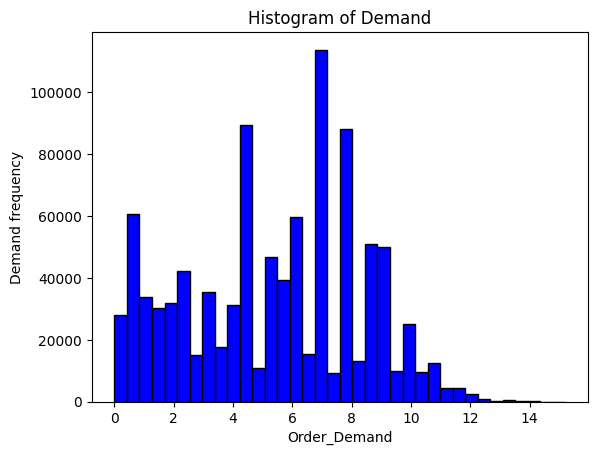

In [72]:
train_data['Order_Demand'] = np.log1p(train_data.Order_Demand)
plt.hist(train_data['Order_Demand'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

plt.title('Histogram of Demand')
plt.xlabel('Order_Demand')
plt.ylabel('Demand frequency')

print('Skew Dist:',train_data['Order_Demand'].skew())
print('Kurtosis Dist:',train_data['Order_Demand'].kurt())

### XGBoost Model

In [73]:
print(test_data.columns)
print(train_data.columns)

Index(['Date', 'Warehouse', 'Product_Code', 'Product_Category', 'year',
       'month', 'day', 'week', 'weekofyear', 'dayofweek', 'weekday',
       'dayofyear', 'quarter', 'is_month_start', 'is_month_end',
       'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end',
       'daily_avg', 'monthly_avg', 'mean_store_item_month', 'item_month_sum',
       'store_month_sum'],
      dtype='object')
Index(['Date', 'Warehouse', 'Product_Code', 'Product_Category', 'Order_Demand',
       'year', 'month', 'day', 'week', 'weekofyear', 'dayofweek', 'weekday',
       'dayofyear', 'quarter', 'is_month_start', 'is_month_end',
       'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end',
       'daily_avg', 'monthly_avg', 'mean_store_item_month', 'item_month_sum',
       'store_month_sum'],
      dtype='object')


In [74]:
#dropping columns
train_data=train_data.drop(['Date'],axis=1)
test_data=test_data.drop(['Date'],axis=1)

In [75]:
test_data.columns

Index(['Warehouse', 'Product_Code', 'Product_Category', 'year', 'month', 'day',
       'week', 'weekofyear', 'dayofweek', 'weekday', 'dayofyear', 'quarter',
       'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end',
       'is_year_start', 'is_year_end', 'daily_avg', 'monthly_avg',
       'mean_store_item_month', 'item_month_sum', 'store_month_sum'],
      dtype='object')

In [76]:
train_data.columns

Index(['Warehouse', 'Product_Code', 'Product_Category', 'Order_Demand', 'year',
       'month', 'day', 'week', 'weekofyear', 'dayofweek', 'weekday',
       'dayofyear', 'quarter', 'is_month_start', 'is_month_end',
       'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end',
       'daily_avg', 'monthly_avg', 'mean_store_item_month', 'item_month_sum',
       'store_month_sum'],
      dtype='object')

### Input Size

In [77]:
test_data.shape

(48452, 23)

In [78]:
train_data.shape

(982985, 24)

In [79]:
test_data.isnull().sum()

Warehouse                0
Product_Code             0
Product_Category         0
year                     0
month                    0
day                      0
week                     0
weekofyear               0
dayofweek                0
weekday                  0
dayofyear                0
quarter                  0
is_month_start           0
is_month_end             0
is_quarter_start         0
is_quarter_end           0
is_year_start            0
is_year_end              0
daily_avg                0
monthly_avg              0
mean_store_item_month    0
item_month_sum           0
store_month_sum          0
dtype: int64

In [80]:
train_data.isnull().sum()

Warehouse                0
Product_Code             0
Product_Category         0
Order_Demand             0
year                     0
month                    0
day                      0
week                     0
weekofyear               0
dayofweek                0
weekday                  0
dayofyear                0
quarter                  0
is_month_start           0
is_month_end             0
is_quarter_start         0
is_quarter_end           0
is_year_start            0
is_year_end              0
daily_avg                0
monthly_avg              0
mean_store_item_month    0
item_month_sum           0
store_month_sum          0
dtype: int64

In [81]:
test_data.dtypes

Warehouse                  int64
Product_Code               int64
Product_Category           int64
year                       int64
month                      int64
day                        int64
week                       int64
weekofyear                 int64
dayofweek                  int64
weekday                    int64
dayofyear                  int64
quarter                    int64
is_month_start             int64
is_month_end               int64
is_quarter_start           int64
is_quarter_end             int64
is_year_start              int64
is_year_end                int64
daily_avg                  int64
monthly_avg                int64
mean_store_item_month      int64
item_month_sum           float64
store_month_sum            int64
dtype: object

In [82]:
train_data.dtypes

Warehouse                  int64
Product_Code               int64
Product_Category           int64
Order_Demand             float64
year                       int64
month                      int64
day                        int64
week                       int64
weekofyear                 int64
dayofweek                  int64
weekday                    int64
dayofyear                  int64
quarter                    int64
is_month_start             int64
is_month_end               int64
is_quarter_start           int64
is_quarter_end             int64
is_year_start              int64
is_year_end                int64
daily_avg                  int64
monthly_avg                int64
mean_store_item_month      int64
item_month_sum             int64
store_month_sum            int64
dtype: object

### Modelling

In [83]:
y=pd.DataFrame()
X=pd.DataFrame()
#y=train_data['Order_Demand']


In [84]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [85]:
x_train,x_test,y_train,y_test = train_test_split(train_data.drop('Order_Demand',axis=1),train_data.pop('Order_Demand'),random_state=123,test_size=0.1)

In [86]:
"""train_size = int(len(train_data) * 0.70)
train_n, test_n = train_data[0:train_size], train_data[train_size:len(train_data)]
print('Observations: %d' % (len(train_data)))
print('Training Observations: %d' % (len(train_n)))
print('Testing Observations: %d' % (len(test_n)))

train_n = pd.DataFrame(train_n)
test_n = pd.DataFrame(test_n)

x_train = train_n.drop('Order_Demand', axis=1)
y_train = train_n.pop('Order_Demand')
x_test = test_n.drop('Order_Demand', axis=1)
y_test = test_n.pop('Order_Demand')


x_train,x_test,y_train,y_test = train_test_split(train_data.drop('Order_Demand',axis=1),train_data.pop('Order_Demand'),random_state=123,test_size=0.2)
"""

"train_size = int(len(train_data) * 0.70)\ntrain_n, test_n = train_data[0:train_size], train_data[train_size:len(train_data)]\nprint('Observations: %d' % (len(train_data)))\nprint('Training Observations: %d' % (len(train_n)))\nprint('Testing Observations: %d' % (len(test_n)))\n\ntrain_n = pd.DataFrame(train_n)\ntest_n = pd.DataFrame(test_n)\n\nx_train = train_n.drop('Order_Demand', axis=1)\ny_train = train_n.pop('Order_Demand')\nx_test = test_n.drop('Order_Demand', axis=1)\ny_test = test_n.pop('Order_Demand')\n\n\nx_train,x_test,y_train,y_test = train_test_split(train_data.drop('Order_Demand',axis=1),train_data.pop('Order_Demand'),random_state=123,test_size=0.2)\n"

In [87]:
y_test.head(2)

43167     8.699681
841537    1.791759
Name: Order_Demand, dtype: float64

In [88]:
x_train.head(2)

,Warehouse,Product_Code,Product_Category,year,month,day,week,weekofyear,dayofweek,weekday,...,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,mean_store_item_month,item_month_sum,store_month_sum
724038,4,613,1,2020,4,8,15,15,2,2,...,0,0,0,0,0,4,5,5,2735,279385581
248203,4,1359,19,2018,2,18,7,7,6,6,...,0,0,0,0,0,24241,24999,24999,36599000,277400663


In [89]:
# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))


Baseline MAE is 2.47


In [90]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
     'eval_metric':'mae',
}

In [91]:
dtrain = xgb.DMatrix(x_train,label=y_train)
dtest = xgb.DMatrix(x_test,label=y_test)
model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[09:51:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:3.54243
[1]	Test-mae:2.59843
[2]	Test-mae:1.96608
[3]	Test-mae:1.56806
[4]	Test-mae:1.33727
[5]	Test-mae:1.21193
[6]	Test-mae:1.14279
[7]	Test-mae:1.10451
[8]	Test-mae:1.08376
[9]	Test-mae:1.07231
[10]	Test-mae:1.06508
[11]	Test-mae:1.06076
[12]	Test-mae:1.05750
[13]	Test-mae:1.05583
[14]	Test-mae:1.05455
[15]	Test-mae:1.05318
[16]	Test-mae:1.05266
[17]	Test-mae:1.05077
[18]	Test-mae:1.04984
[19]	Test-mae:1.04862
[20]	Test-mae:1.04834
[21]	Test-mae:1.04727
[22]	Test-mae:1.04632
[23]	Test-mae:1.04564
[24]	Test-mae:1.04499
[25]	Test-mae:1.04489
[26]	Test-mae:1.04434
[27]	Test-mae:1.04387
[28]	Test-mae:1.04367
[29]	Test-mae:1.04360
[30]	Test-mae:1.04356
[31]	Test-mae:1.04297
[32]	Test-mae:1.04285
[33]	Test-mae:1.04257
[34]	Test-mae:1.04229
[35]	Test-mae:1.04200
[36]	Test-mae:1.04185
[37]	Test-mae:1.04165
[38]	Test-mae:1.04090
[39]	Test-mae:1.04081
[40]	Test-m

In [92]:
print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best MAE: 1.03 with 265 rounds


In [ ]:
"""
def XGBmodel(x_train,x_test,y_train,y_test):
    matrix_train = xgb.DMatrix(x_train,label=y_train)
    matrix_test = xgb.DMatrix(x_test,label=y_test)
    model=xgb.train(params={'objective':'reg:linear','eval_metric':'mae','max_depth':6,'eta':0.2}
                    ,dtrain=matrix_train,num_boost_round=500, 
                    early_stopping_rounds=20,evals=[(matrix_test,'test')],)
    return model

model=XGBmodel(x_train,x_test,y_train,y_test)
"""

### Submission

In [93]:
test_data

,Warehouse,Product_Code,Product_Category,year,month,day,week,weekofyear,dayofweek,weekday,...,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,mean_store_item_month,item_month_sum,store_month_sum
0,2,202,7,2022,1,3,1,1,0,0,...,0,0,0,0,0,1810,1538,1538,147913.0,44830949
1,2,209,7,2022,1,3,1,1,0,0,...,0,0,0,0,0,905,982,982,31483.0,44830949
2,2,250,7,2022,1,9,1,1,6,6,...,0,0,0,0,0,3036,20,20,11312.0,44830949
3,2,471,15,2022,1,9,1,1,6,6,...,0,0,0,0,0,20,21,21,360.0,44830949
4,2,1166,6,2022,1,4,1,1,1,1,...,0,0,0,0,0,154000,133125,133125,2130000.0,44830949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48447,4,2171,7,2021,12,14,50,50,1,1,...,0,0,0,0,0,2,1,1,63.0,217622190
48448,4,2171,7,2021,12,14,50,50,1,1,...,0,0,0,0,0,2,1,1,63.0,217622190
48449,4,2171,7,2021,12,21,51,51,1,1,...,0,0,0,0,0,2,1,1,63.0,217622190
48450,4,2171,7,2021,12,19,50,50,6,6,...,0,0,0,0,0,3,1,1,63.0,217622190


In [94]:
pd.DataFrame(test_data).to_csv('../data/cleaned_test_data.csv')

In [95]:
#test_data1 = pd.read_csv('../data/cleaned_test_data.csv')
#submission = pd.DataFrame(test_data1.pop('Product_Code'))
submission = pd.DataFrame()
y_pred = model.predict(xgb.DMatrix(x_test), ntree_limit = model.best_ntree_limit)

submission['Order_Demand']= y_pred

submission.to_csv('../data/submission.csv',index=False)

In [96]:
submission.tail()

,Order_Demand
98294,8.972479
98295,8.390564
98296,3.462685
98297,4.829473
98298,6.915793


In [97]:
x_test.describe()

,Warehouse,Product_Code,Product_Category,year,month,day,week,weekofyear,dayofweek,weekday,...,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,mean_store_item_month,item_month_sum,store_month_sum
count,98299.000000,98299.000000,98299.000000,98299.000000,98299.000000,98299.000000,98299.000000,98299.000000,98299.000000,98299.000000,...,98299.000000,98299.000000,98299.000000,98299.000000,98299.000000,98299.000000,98299.000000,98299.000000,9.829900e+04,9.829900e+04
mean,3.420259,1113.454338,14.907090,2018.861392,6.298742,15.552457,25.672102,25.672102,2.283543,2.283543,...,0.032747,0.013978,0.009400,0.000173,0.000468,4964.633628,4974.960793,4974.960793,1.871156e+06,2.067522e+08
std,1.070638,574.452677,7.897458,1.345004,3.375060,8.820084,14.720086,14.720086,1.925533,1.925533,...,0.177975,0.117399,0.096497,0.013150,0.021627,15363.710906,15214.752468,15214.752468,5.450555e+06,1.032374e+08
min,1.000000,1.000000,1.000000,2016.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,9.581594e+06
25%,3.000000,623.000000,7.000000,2018.000000,3.000000,8.000000,13.000000,13.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,52.000000,52.000000,52.000000,3.136000e+03,9.234429e+07
50%,4.000000,1286.000000,19.000000,2019.000000,6.000000,16.000000,25.000000,25.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,796.000000,790.000000,790.000000,7.300000e+04,2.605632e+08
75%,4.000000,1465.000000,19.000000,2020.000000,9.000000,23.000000,38.000000,38.000000,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4754.000000,4769.000000,4769.000000,8.400000e+05,2.793856e+08
max,4.000000,2172.000000,33.000000,2021.000000,12.000000,31.000000,53.000000,53.000000,6.000000,6.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,670681.000000,580160.000000,580160.000000,4.361900e+07,2.987888e+08


In [98]:
test_data

,Warehouse,Product_Code,Product_Category,year,month,day,week,weekofyear,dayofweek,weekday,...,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,mean_store_item_month,item_month_sum,store_month_sum
0,2,202,7,2022,1,3,1,1,0,0,...,0,0,0,0,0,1810,1538,1538,147913.0,44830949
1,2,209,7,2022,1,3,1,1,0,0,...,0,0,0,0,0,905,982,982,31483.0,44830949
2,2,250,7,2022,1,9,1,1,6,6,...,0,0,0,0,0,3036,20,20,11312.0,44830949
3,2,471,15,2022,1,9,1,1,6,6,...,0,0,0,0,0,20,21,21,360.0,44830949
4,2,1166,6,2022,1,4,1,1,1,1,...,0,0,0,0,0,154000,133125,133125,2130000.0,44830949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48447,4,2171,7,2021,12,14,50,50,1,1,...,0,0,0,0,0,2,1,1,63.0,217622190
48448,4,2171,7,2021,12,14,50,50,1,1,...,0,0,0,0,0,2,1,1,63.0,217622190
48449,4,2171,7,2021,12,21,51,51,1,1,...,0,0,0,0,0,2,1,1,63.0,217622190
48450,4,2171,7,2021,12,19,50,50,6,6,...,0,0,0,0,0,3,1,1,63.0,217622190


In [99]:
from sklearn.metrics import explained_variance_score
explained_variance_score(y_test, y_pred)  

0.765693803033487

In [100]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

2.0222855920749563

In [101]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.7656937364639587

<AxesSubplot: >

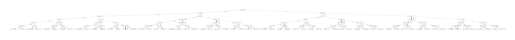

In [102]:
xgb.plot_tree(model,num_trees=3)

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Feature', ylabel='Importance'>

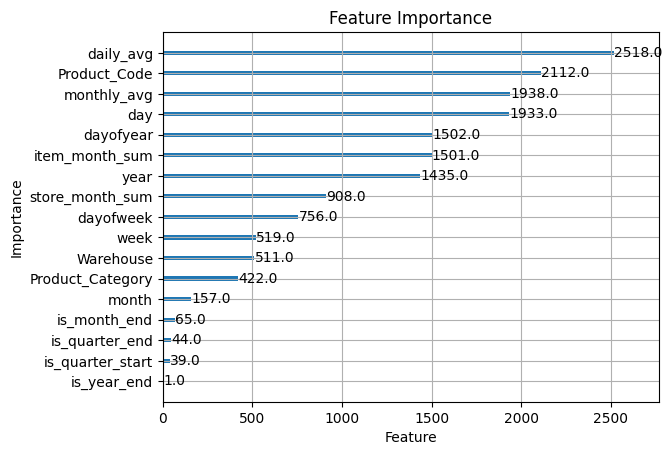

In [103]:
from xgboost import plot_importance
plot_importance(model, xlabel='Feature', ylabel='Importance', title='Feature Importance')

In [ ]:
#Save the model to a pickle file
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:

# Load the model from the pickle file
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)